In [1]:
import sys
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import json
import ast
import json
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
import json
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
import keras.backend as K
import string
import preprocessor as p
from preprocessing import *
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_file = '../data/raw/twitter-sentpol/SENTIPOLC Sentiment Polarity Classification - Evalita 2016.csv'
test_file = '../data/raw/twitter-sentpol/test_set_sentipolc16_gold2000.csv'

## Load Train and Test Dataset

In [3]:
df_test = pd.read_csv(test_file)
df_train = pd.read_csv(train_file)
df_it = pd.concat([df_train, df_test])
df_it.head(3)

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,122449983151669248,1,0,1,0,0,1,1,Intanto la partita per Via Nazionale si compli...
1,125485104863780865,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà Mario Monti..."
2,125513454315507712,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà #editoriale..."


##  Pre-processing

We replace URL, MENTION, HASHTAG, and NUMBER with labels. 

In [4]:
df_it['text_flags'] = df_it['text'].apply(lambda x: p.tokenize(x))

#### Normalize the text:
     - Standardize case (lower)
     - Remove punctuation

In [5]:
df_it['text_flag_norm'] = df_it['text_flags'].apply(normalize)

A questo punto procediamo con la seguente strategia. 

__Le parole delle recensioni che fanno parte del lessico vengono sostituite dai rispettivi tag che indicano la polarità della parola.__

Si sceglie di operare questa sostituzione con l'obiettivo di semplificare al modello l'individuazione di parole positive e negative.

In [6]:
df_it['review_text_token'] = df_it['text_flag_norm'].apply(lambda x: x.split())
df_it['review_text_flag'] = df_it['review_text_token'].apply(substitute_label)

In [7]:
df_it['review_text_token_flag'] = df_it['review_text_flag'].apply(lambda x: x.split())
df_it.to_csv('../data/output/twitter-sentpol/preprocessed_twitter_final.csv', sep = ';')
df_it.head(3)

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text,text_flags,text_flag_norm,review_text_token,review_text_flag,review_text_token_flag
0,122449983151669248,1,0,1,0,0,1,1,Intanto la partita per Via Nazionale si compli...,Intanto la partita per Via Nazionale si compli...,intanto la partita per via nazionale si compli...,"[intanto, la, partita, per, via, nazionale, si...",intanto la partita $POS $NEG nazionale si comp...,"[intanto, la, partita, $POS, $NEG, nazionale, ..."
1,125485104863780865,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà Mario Monti...","False illusioni, sgradevoli realtà Mario Monti...",false illusioni sgradevoli realtà mario monti ...,"[false, illusioni, sgradevoli, realtà, mario, ...",false illusioni sgradevoli $POS mario monti ur...,"[false, illusioni, sgradevoli, $POS, mario, mo..."
2,125513454315507712,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà #editoriale...","False illusioni, sgradevoli realtà $HASHTAG$ d...",false illusioni sgradevoli realtà hashtag di m...,"[false, illusioni, sgradevoli, realtà, hashtag...",false illusioni sgradevoli $POS hashtag di mar...,"[false, illusioni, sgradevoli, $POS, hashtag, ..."


## Vettorizzazione dei testi
* Creazione del vocabolario che mappa i sincoli termini ai rispettivi indici

In [8]:
total_words = set([w for list_words in df_it['review_text_token_flag'] for w in list_words])
print ('Number of unique words: {}'.format(len(total_words)))

Number of unique words: 13835


In [9]:
vocabolario_index = {w:idx for idx,w in enumerate(list(total_words))}
index_vocabolario = {idx:w for w, idx in vocabolario_index.items()}

In [10]:
with open('../data/output/twitter-sentpol/vocabolario_twitter.json', 'w') as f:
    json.dump(vocabolario_index, f)

In [11]:
df_it['review_text_token_flag_index_list'] = df_it['review_text_token_flag'].apply(replace_word_index_twitter)

#### We focus on the overall Negative/Positive polarity

Prendo quelli la cui somma è pari ad 1, che indica che si tratta di tweet o positivi o negativi

In [12]:
df_it['review_rating'] = (df_it['opos'] + df_it['oneg'])

Keep the sum = 1

In [13]:
df_it = df_it[df_it['review_rating'] == 1]
df_it['review_rating_01'] = df_it['opos']

df_it['review_rating_01'].value_counts()

0    3277
1    1927
Name: review_rating_01, dtype: int64

We observe that the classes are unbalanced.

## Create train and validation set

In [14]:
from train_test import *

In [15]:
df_validation, df_majority, df_minority = create_balanced_validation(df_it, 0, percentage = 5)

## Balance the dataset

In [16]:
from balancing import *

In [17]:
df_downsampled = downsample_majority_class(df_majority, df_minority)

1    1791
0    1791
Name: review_rating_01, dtype: int64


## Define X and Y for training

In [18]:
x_train_pad, y_train, x_validation_pad, y_validation, max_len_seq, max_idx = train_validation_twitter(df_downsampled, df_validation)

max len seq 40
max id 13834


## Split in train and test

We split in train and set using the Stratified Shuffle Split that draws sample s.t. the proportin of the classes holds both in the train and test.

In [19]:
split_train_test = StratifiedShuffleSplit(1,test_size=0.2, random_state=123456)

for train, test in split_train_test.split(x_train_pad, y_train):
    x_train_pad_split, y_train_pad_split = x_train_pad[train], y_train[train]
    x_val_pad_split, y_val_pad_split = x_train_pad[test], y_train[test]

## Build the model

1. output_dim=20, filters=64, filters=16, kernel_size=2, strides=1, Adagrad(), batch_size=40, 5 epochs
2. output_dim=100, filters=48, strides=1,  filters=16, strides=2

1 e 2 precision e recall invertiti

In [20]:
from evaluation_metrics import *

In [21]:
def build_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_idx+1, output_dim=20, input_length=max_len_seq))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adagrad(), metrics=['accuracy', precision, recall, fbeta_score])
    
    return model

In [22]:
model = build_model()
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 20)            276700    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 64)            6464      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 16)            2064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                850       
___________________________________________________________

In [23]:
history = model.fit(x_train_pad_split, y_train_pad_split, validation_data=(x_val_pad_split, y_val_pad_split),
                    batch_size=40, validation_split=0.2, epochs=5)

Train on 2865 samples, validate on 717 samples
Epoch 1/5
2865/2865 [==============================] - 1s 386us/step - loss: 0.6738 - acc: 0.6024 - precision: 0.6528 - recall: 0.4234 - fbeta_score: 0.4761 - val_loss: 0.6527 - val_acc: 0.6541 - val_precision: 0.6665 - val_recall: 0.6472 - val_fbeta_score: 0.6536
Epoch 2/5
2865/2865 [==============================] - 1s 247us/step - loss: 0.5786 - acc: 0.7253 - precision: 0.7480 - recall: 0.6974 - fbeta_score: 0.7125 - val_loss: 0.6196 - val_acc: 0.6764 - val_precision: 0.6951 - val_recall: 0.6342 - val_fbeta_score: 0.6608
Epoch 3/5
2865/2865 [==============================] - 1s 261us/step - loss: 0.4529 - acc: 0.8112 - precision: 0.8113 - recall: 0.8039 - fbeta_score: 0.8020 - val_loss: 0.6458 - val_acc: 0.6722 - val_precision: 0.6751 - val_recall: 0.6695 - val_fbeta_score: 0.6694
Epoch 4/5
2865/2865 [==============================] - 1s 235us/step - loss: 0.3396 - acc: 0.8719 - precision: 0.8686 - recall: 0.8778 - fbeta_score: 0.8698 -

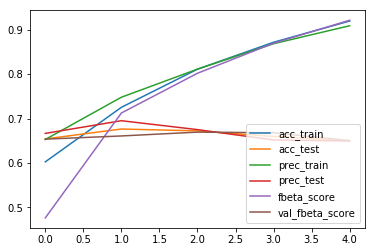

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['fbeta_score'])
plt.plot(history.history['val_fbeta_score'])
plt.legend(['acc_train', 'acc_test', 'prec_train', 'prec_test', 'fbeta_score', 'val_fbeta_score'], loc='lower right')

In [25]:
prediction = model.predict_classes(x_validation_pad)

In [26]:
from sklearn import metrics

## Evaluate the model on the validation set

* We compute the class predictions
* We see the evaluation using precision, recall, f1 and accuracy

In [27]:
prediction = model.predict_classes(x_validation_pad)

In [28]:
evaluate_model(model, x_validation_pad, y_validation)

Modelevaluation: 
Accuracy: 0.7269230769230769 
Precision: 0.7384615384615385 
Recall: 0.7218045112781954 
F1: 0.7300380228136882


These metrics are computed on a validation set that has been randomly created (explanation throughout the pipeline). Thus, if the notebook will be executed again those can vary.

__Il modello non risulta essere particolarmente stabile poichè la quantità di dati che abbiamo è molto ridotta. Sarebbe ottimo riuscire ad ottenere i tweet del 2014 di cui abbiamo sentiment e indici ma non testo, Pertanto dovremo scrivere un mini crawler.__

